In [1]:
# Ian Ong
# 10.27.2020

# Diagnostics
!python -V
from platform import python_version
print('notebook python version: {}'.format(python_version()))

# import modules
import sys
import os
import os.path
import time
try:
   import cPickle as pickle
except:
   import pickle
import numpy as np
import pandas as pd
print('pandas version: {}'.format(pd.__version__))
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns
import bct
import re

# convert number of seconds to hh:mm:ss
def convertSeconds(time): 
    seconds = time % 3600 
    hours = time // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    if seconds < 10:
        seconds = "0" + str(seconds)
    if minutes < 10:
        minutes = "0" + str(minutes)
    if hours < 10:
        hours = "0" + str(hours)
    return ":".join(str(n) for n in [hours,minutes,seconds])

print('All modules imported.')

Python 3.5.2 :: Anaconda 4.2.0 (64-bit)
notebook python version: 3.9.0
pandas version: 1.1.3
All modules imported.


In [2]:
# load in pickle files, unpickle as needed
pickle_dir = '/mnt/local/gdrive/public/USERS/ianzyong/network-states/data/sub-RID0175/connectivity_matrices/functional/eeg'
files = os.listdir(pickle_dir)

# get start times
start_times = [int(re.findall(r'[0-9]+', f)[2]) for f in files]
sorted_times = sorted(start_times)
formatted_time_in_order = [convertSeconds(int(time/1000000)-1) for time in sorted_times]

# sort files by start time
sorted_files = [x for _,x in sorted(zip(start_times,files))]

# load in connectivity matrices 
pickle_data = [pd.read_pickle("{}/{}".format(pickle_dir,f)) for f in sorted_files]

print("Pickle files loaded and read.")

Pickle files loaded and read.


In [3]:
band = 0 # band to run calcuations on

# if the result files don't already exist
if not os.path.isfile("HUP116_efficiency.npy") or not os.path.isfile("HUP116_avg_node_strength.npy"):
    
    efficiency = []
    avg_node_strength = []
    
    # start timer
    start = time.time()

    for k in range(len(pickle_data)):
        patient_matrices = np.moveaxis(pickle_data[k][band],2,0) # make the first axis the time axis
        # calculate global efficiency for every second in the interval
        efficiency.append([bct.efficiency_wei(patient_matrices[arr]) for arr in range(patient_matrices.shape[0])])
        # calculate average node strength for RA3, RA4, RH2, RH3, RH4 for every second in the interval
        node_strengths = [bct.strengths_und(patient_matrices[arr]) for arr in range(patient_matrices.shape[0])]
        avg_node_strength.append([np.mean([node_strengths[j][node] for node in [6, 7, 31, 32, 33]]) for j in range(patient_matrices.shape[0])])
        print('Mean efficiency = {}, mean average node strength in epileptogenic zone = {}, time = {}'.format(np.round(np.mean(efficiency[k]),8), np.round(np.mean(avg_node_strength[k]),8), start_times[k]))

    # end timer
    end = time.time()

    print("Done. Time elapsed = {}".format(convertSeconds(int(end - start))))

    # save results to file
    np.save("HUP116_efficiency.npy",efficiency)
    np.save("HUP116_avg_node_strength.npy",avg_node_strength)
    
else:
    print("Files already in directory.")

Mean efficiency = 0.29517166, mean average node strength in epileptogenic zone = 14.83007378, time = 1597570
Mean efficiency = 0.2888696, mean average node strength in epileptogenic zone = 14.63882606, time = 3601597570
Mean efficiency = 0.28320633, mean average node strength in epileptogenic zone = 14.55463199, time = 7201597570
Mean efficiency = 0.29059021, mean average node strength in epileptogenic zone = 14.51506025, time = 10801597570
Mean efficiency = 0.2846952, mean average node strength in epileptogenic zone = 14.31049644, time = 14401597570
Mean efficiency = 0.28447564, mean average node strength in epileptogenic zone = 14.38071267, time = 18001597570
Mean efficiency = 0.28745349, mean average node strength in epileptogenic zone = 14.48983313, time = 21601597570
Mean efficiency = 0.29150683, mean average node strength in epileptogenic zone = 14.63131096, time = 25201597570
Mean efficiency = 0.29400268, mean average node strength in epileptogenic zone = 14.87923811, time = 288

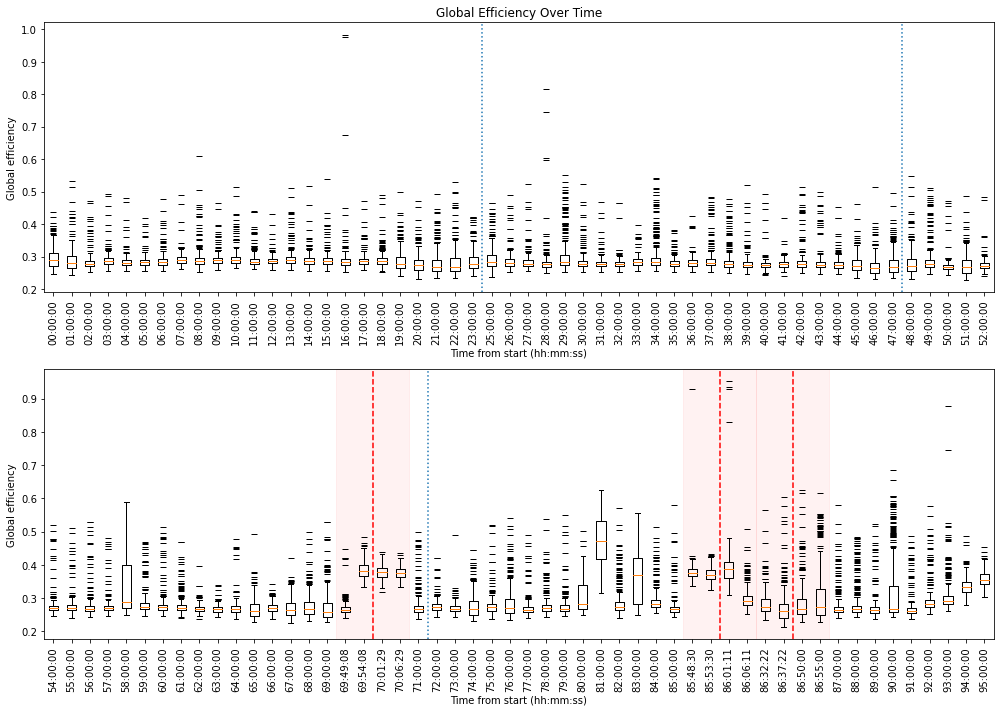

In [33]:
# load in files
efficiency = np.load("HUP116_efficiency.npy",allow_pickle=True)
avg_node_strength = np.load("HUP116_avg_node_strength.npy",allow_pickle=True)

# sort data by start time
efficiency = [x for _,x in sorted(zip(start_times,efficiency))]
avg_node_strength = [x for _,x in sorted(zip(start_times,avg_node_strength))]

outlier_marker = dict(markerfacecolor='k', marker='_')

# boxplots for global efficiency

fig, axs = plt.subplots(2, 1)
fig.set_size_inches(14, 10)

axs[0].boxplot(efficiency[0:len(efficiency)//2], flierprops=outlier_marker)
axs[0].set_xticklabels(formatted_time_in_order[0:len(efficiency)//2],rotation=90)
axs[0].set_title("Global Efficiency Over Time")
axs[0].set_xlabel("Time from start (hh:mm:ss)")
axs[0].set_ylabel("Global efficiency")

axs[0].axvline(x=24.5,ls=':')
axs[0].axvline(x=47.5,ls=':')

axs[1].boxplot(efficiency[1+len(efficiency)//2:len(efficiency)], flierprops=outlier_marker)
axs[1].set_xticklabels(formatted_time_in_order[1+len(efficiency)//2:len(efficiency)],rotation=90)
axs[1].set_xlabel("Time from start (hh:mm:ss)")
axs[1].set_ylabel("Global efficiency")

axs[1].axvline(x=21.5,ls=':')
axs[1].axvspan(16.5, 20.5, alpha=0.05, color='red')
axs[1].axvline(x=18.5,ls='--', color='red')
axs[1].axvspan(35.5, 39.5, alpha=0.05, color='red')
axs[1].axvline(x=37.5,ls='--', color='red')
axs[1].axvspan(39.5, 43.5, alpha=0.05, color='red')
axs[1].axvline(x=41.5,ls='--', color='red')

plt.tight_layout()
plt.show()

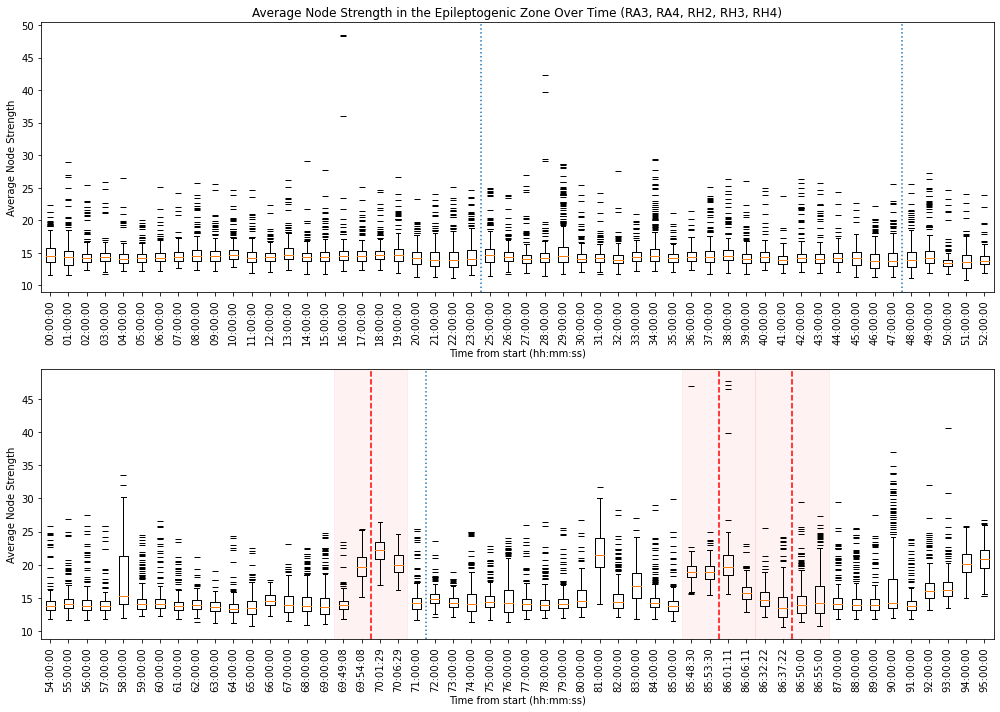

In [36]:
# boxplots for average node strength in the epileptogenic zone

fig, axs = plt.subplots(2, 1)
fig.set_size_inches(14, 10)

axs[0].boxplot(avg_node_strength[0:len(avg_node_strength)//2], flierprops=outlier_marker)
axs[0].set_xticklabels(formatted_time_in_order[0:len(avg_node_strength)//2],rotation=90)
axs[0].set_title("Average Node Strength in the Epileptogenic Zone Over Time (RA3, RA4, RH2, RH3, RH4)")
axs[0].set_xlabel("Time from start (hh:mm:ss)")
axs[0].set_ylabel("Average Node Strength")

axs[0].axvline(x=24.5,ls=':')
axs[0].axvline(x=47.5,ls=':')

axs[1].boxplot(avg_node_strength[1+len(avg_node_strength)//2:len(avg_node_strength)], flierprops=outlier_marker)
axs[1].set_xticklabels(formatted_time_in_order[1+len(avg_node_strength)//2:len(avg_node_strength)],rotation=90)
axs[1].set_xlabel("Time from start (hh:mm:ss)")
axs[1].set_ylabel("Average Node Strength")

axs[1].axvline(x=21.5,ls=':')
axs[1].axvspan(16.5, 20.5, alpha=0.05, color='red')
axs[1].axvline(x=18.5,ls='--', color='red')
axs[1].axvspan(35.5, 39.5, alpha=0.05, color='red')
axs[1].axvline(x=37.5,ls='--', color='red')
axs[1].axvspan(39.5, 43.5, alpha=0.05, color='red')
axs[1].axvline(x=41.5,ls='--', color='red')

plt.tight_layout()
plt.show()